In [60]:
import requests
import pandas as pd
import sqlite3
import json
import matplotlib.pyplot as plt
import folium
from folium import plugins
%matplotlib inline
f = open("yelp_api_key","r")
api_key = f.readline()
total = 0
my_house_coordinates = (41.036923,-73.756332)

# This is just a personal research that I did in order to find the best dentist in White Plains, NY where I live.  In order to accomplish this I do a call to Yelp API searching for all dentists in my area. The records get loaded in a sqlite database. Two functions are used. One of them will get the records from Yelp and the other one will load the records in the database. They can both be restarted. A total of 492 records were retrieved. 


In [15]:
def load_records_in_db(yelp_response_bus):
# This function loads the records in the dentist database
    conn = sqlite3.connect('dentistdb.sqlite')
    cur = conn.cursor()
# This will create the table only if it does not exist to allow for reruns
    cur.executescript('''
    CREATE TABLE if not exists Dentist (
        yelp_id TEXT NOT NULL PRIMARY KEY UNIQUE,
        name   TEXT,
        review_count INTEGER,
        rating REAL,
        longitude TEXT,
        latitude TEXT,
        address TEXT,
        phone TEXT)''')
# This loops goes through each record and extracts the fields to load in the database
    for business in yelp_response_bus:
        yelp_id = business['id']
        name = business['name']
        review_count = business['review_count']
        rating = float(business['rating'])
        latitude = business['coordinates']['latitude']
        longitude = business['coordinates']['longitude']
# This is just to make sure that the address fields are not empty
        
        if (len(business['location']['display_address'])) == 1:
            address = business['location']['display_address'][0]
        elif (len(business['location']['display_address'])) == 2:
            address = business['location']['display_address'][0] + ', ' + business['location']['display_address'][1]
        else:
            address = 'n/a'
        phone = business['display_phone']
# This is where values get inserted in the table
        cur.execute('''INSERT OR IGNORE INTO Dentist (yelp_id, name,review_count, rating, latitude, longitude, address, phone)
        VALUES (?, ?, ?, ?, ?, ?, ?, ? )''', (yelp_id, name, review_count, rating, latitude, longitude, address, phone)) 
        conn.commit()
   



In [3]:
def retrieve_dentist(term= 'Dentists', location = 'White Plains, NY', offset = 0):
# This is the function that retrieves records from yelp
    SEARCH_LIMIT = 50


    url = 'https://api.yelp.com/v3/businesses/search'

    headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }

    url_params = {
                'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+'),
                'limit': SEARCH_LIMIT,
                'offset':  offset
            }
    response = requests.get(url, headers=headers, params=url_params)
    yelp_response = response.json()
    total = yelp_response['total']
    response_businesses = yelp_response['businesses']
    times = total / SEARCH_LIMIT
    print("There are " + str(yelp_response['total']) + " records in this search")
    load_records_in_db(yelp_response['businesses'])
  

In [84]:
retrieve_dentist('Dentists','White Plains, NY', 0)

There are 492 records in this search


# The following loop will attempt to get all records for dentists in White Plains from Yelp

In [ ]:
for i in range (2,total):
    retrieve_dentist('Dentists','White Plains, NY', i* 50 )
    

# This is where I connect to sqlite and extract the table to load a dataframe

In [16]:
conn = sqlite3.connect("dentistdb.sqlite")

# I get the records from the database to create a dataframe 

In [17]:
dentist_df = pd.read_sql_query("select * from dentist;", conn)

In [18]:
dentist_df.head()

,yelp_id,name,review_count,rating,longitude,latitude,address,phone
0,7v5QzridJvYp7ZemIzrkyQ,"Alpha Dental Ruslan Korobeinik, DDS",14,4.5,-73.7729081,41.0302963,"16 Martine Ave, White Plains, NY 10606",(914) 292-5309
1,h6GEKE8VWXWWz1-Cw_npGA,"The Dental Design Center - Ira J. Handschuh, D...",11,5.0,-73.8048356,41.0394067,"280 Dobbs Ferry Rd, Ste 104",(914) 683-5898
2,Kp3KrYBy0MuBbt0qgDXi7A,Scarsdale Dental Center,21,5.0,-73.824941,40.988031,"1075 Central Park Ave, Ste 200",(914) 713-4999
3,F4UsiMk-CG0FiFiuuMN5EQ,Westchester Dental Group,3,4.5,-73.740349,41.031601,"220 Westchester Ave, White Plains, NY 10604",(914) 997-1154
4,PHdeUvTl2pJhPWcwX31EsA,White Plains Dental Care,7,4.0,-73.7656174600124,41.0298619419336,"114 Mamaroneck Ave, White Plains, NY 10601",(914) 615-9888


In [19]:
dentist_df.tail()

,yelp_id,name,review_count,rating,longitude,latitude,address,phone
485,6gTKQAnCJdCIol12Y82R5g,Children's Dentistry of the Palisades,1,1.0,-73.9546219,41.0354939,"6 Independence Ave, Tappan, NY 10983",(845) 359-8080
486,Hd0l6qzTx-w658eV2p3lxA,Westchester Medical Center,61,2.0,-73.8040997,41.0877392,"100 Woods Rd, Valhalla, NY 10595",(914) 493-7000
487,4XIHiSKWSecUjVFRfowT5w,DDS Pest Control Service,1,5.0,-73.9005127,40.7304916,"53-30 65th Pl, Queens, NY 11378",(718) 485-0421
488,REq2WBDJJYw5xSqQphbaEQ,Open Door Family Medical Centers,8,2.0,-73.665145,40.997611,"5 Grace Church St, Port Chester, NY 10573",(914) 937-8899
489,_C6jLduYlTVcqEmfCs_skw,Nyack Hospital,38,2.0,-73.92603,41.09595,"160 N Midland Ave, Nyack, NY 10960",(845) 348-2000


In [20]:
dentist_df.describe()

,review_count,rating
count,490.000000,490.000000
mean,4.167347,3.801020
std,5.637712,1.425985
min,1.000000,1.000000
25%,1.000000,3.000000
50%,2.000000,4.500000
75%,5.000000,5.000000
max,61.000000,5.000000


In [21]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

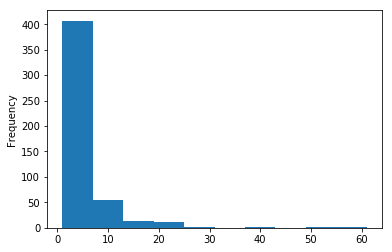

In [22]:
dentist_df['review_count'].plot.hist()

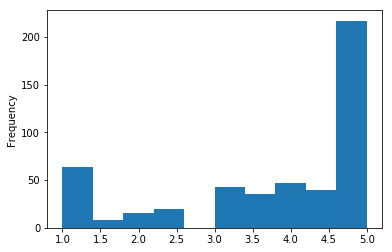

In [23]:
dentist_df['rating'].plot.hist()

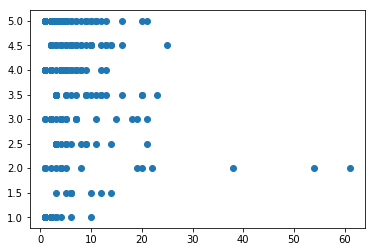

In [24]:
plt.scatter(x=dentist_df['review_count'], y=dentist_df['rating'])
plt.show()

In [25]:
dentist_df.corr()

,review_count,rating
review_count,1.000000,-0.075723
rating,-0.075723,1.000000


# In order to find the best dentists I select the ones with a 5.0 rating 

In [26]:
high_rating = dentist_df['rating'] == 5.0

# I also want to select the dentists that have many reviews

In [27]:
many_reviews = dentist_df['review_count'] > 15

In [28]:
best_dentist_df = dentist_df[high_rating & many_reviews]

# The DataFrame below shows me 3 dentists that meet the criteria of having a high rating as well as many reviews

In [29]:
best_dentist_df

,yelp_id,name,review_count,rating,longitude,latitude,address,phone
2,Kp3KrYBy0MuBbt0qgDXi7A,Scarsdale Dental Center,21,5.0,-73.824941,40.988031,"1075 Central Park Ave, Ste 200",(914) 713-4999
13,zMqL7iPe8stMK4hlQYDEzA,Greenwich Family & Cosmetic Dentistry,20,5.0,-73.631304,41.028708,"4 Dearfield Dr, Ste G2",(203) 869-4755
54,9hG7ZHaFxujImsr0LNqiNg,Westchester Oral & Maxillofacial Surgery & Imp...,16,5.0,-73.6950707,41.0065588,"2975 Westchester Ave, Ste G02",(914) 902-5780


In [25]:
len(best_dentist_df)

3

In [36]:
# 
dentist_df = dentist_df.astype({"latitude": float, "longitude": float})


In [37]:
type(dentist_df['latitude'][1])

numpy.float64

In [85]:
locations = dentist_df[['latitude', 'longitude']]
locationlist = locations.values.tolist()

In [87]:
map = folium.Map(location=my_house_coordinates, zoom_start=10)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=dentist_df['name'][point]).add_to(map)
map

# The map above disappeared but it was showing all records and the markers were showing the names of all dentists

In [63]:
long_List = best_dentist_df['longitude'].tolist()

In [64]:
lat_List


['40.988031', '41.028708', '41.0065588']

In [65]:
long_List

['-73.824941', '-73.631304', '-73.6950707']

# The above are the coordinates for the dentists found 

In [79]:
new_points = []
for i in range(0,3):
    point = ()
    point = (float(lat_List[i]),float(long_List[i]))
    new_points.append(point)

In [80]:
new_points

[(40.988031, -73.824941), (41.028708, -73.631304), (41.0065588, -73.6950707)]

In [81]:
type(new_points)

list

In [82]:
map2 = folium.Map(location=my_house_coordinates, zoom_start=10)
for point in range(0, len(new_points)):
    folium.Marker(new_points[point]).add_to(map2)
map2

# The above markers shows the three dentists found